# **Feature Engineering Tutorial with Titanic**

Source: https://www.kaggle.com/kernels/scriptcontent/13445201/download

> ## **0. Introduction**

> **tl;dr** Created many features by grouping and used a simple ensemble model.

> I decided to write this kernel because **Titanic: Machine Learning from Disaster** is one of my favorite competitions on Kaggle. This is a basic level kernel which focuses on **Exploratory Data Analysis** and **Feature Engineering**. A lot of people start Kaggle with this competition and they get lost in extremely long tutorial kernels. This is a relatively short kernel compared to others. I hope this will be a guide for starters and inspire them with Feature Engineering ideas.

> **Titanic: Machine Learning from Disaster** is a great competition to apply domain knowledge for feature engineering, so I made a research and learned a lot about Titanic. There are many secrets to be revealed beneath the Titanic dataset. I tried to find out some of those secret factors that had affected the survival of passengers when the Titanic was sinking. I believe there are features still waiting to be discovered. 

> This kernel has **3** main parts; **Exploratory Data Analysis**, **Feature Engineering** and **Machine Learning**, and it can achieve top **5%** LB score with a simple tuned Random Forest Classifier. It takes 30 seconds to run whole notebook. I have been revisiting this kernel from time to time. If you have any idea that might improve this kernel, please be sure to comment or fork and experiment as you like.

> **TODO;**
* The continuous features (`Fare` and `Age`) are binned based on their quantiles. In order to increase the information gain via binning, entropy based binning can be implemented. This way the most homogeneous groups in those features can be revealed.

>> ### **0.1. Libraries**

In [80]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

import string
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

SEED = 42

>> ### **0.2. Loading the Dataset**
* Training set has **891** rows and test set has **418** rows.
* Training set have **12** features and test set have **11** features.
* One extra feature in the training set is `Survived` feature, which is the class of a row.

In [81]:
import os
os.listdir()

['.ipynb_checkpoints',
 'submissions.csv',
 'test.csv',
 'titanic.ipynb',
 'train.csv']

In [82]:
data=pd.read_csv('train.csv')

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [84]:
data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [85]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


> ## **1. Exploratory Data Analysis**

>> ### **1.1. Overview**
* `PassengerId` feature is the unique id of the row and it doesn't have any effect on `Survived`.
* `Survived` feature is binary (**0** or **1**); 
    - **1 = Survived**
    - **0 = Not Survived**
* `Pclass` (Passenger Class) feature is the socio-economic status of the passenger. It is a categorical ordinal feature which has **3** unique values (**1**,  **2 **or **3**);
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
* `Name`, `Sex` and `Age` features are self-explanatory.
* `SibSp` feature is the total number of the passengers' siblings and spouse.
* `Parch` feature is the total number of the passengers' parents and children.
* `Ticket` feature is the ticket number of the passenger.
* `Fare` feature is the passenger fare.
* `Cabin` feature is the cabin number of the passenger.
* `Embarked` is port of embarkation. It is a categorical feature and it has **3** unique values (**C**, **Q** or **S**);
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

In [86]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


PassengerId  Survived  Pclass                        Name   Sex   Age  \
122          123         0       2        Nasser, Mr. Nicholas  male  32.5   
397          398         0       2     McKane, Mr. Peter David  male  46.0   
283          284         1       3  Dorking, Mr. Edward Arthur  male  19.0   

     SibSp  Parch      Ticket     Fare Cabin Embarked  
122      1      0      237736  30.0708   NaN        C  
397      0      0       28403  26.0000   NaN        S  
283      0      0  A/5. 10482   8.0500   NaN        S

In [87]:
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


PassengerId  Pclass                        Name     Sex   Age  SibSp  \
273         1165       3          Lennon, Miss. Mary  female   NaN      1   
11           903       1  Jones, Mr. Charles Cresson    male  46.0      0   
348         1240       2            Giles, Mr. Ralph    male  24.0      0   

     Parch  Ticket  Fare Cabin Embarked  
273      0  370371  15.5   NaN        Q  
11       0     694  26.0   NaN        S  
348      0  248726  13.5   NaN        S

>> ### **1.2. Dealing with Missing Values**
As seen from below, there are some columns have missing values. The `display_missing` function shows the sum of missing values in each column in both training and test set.
* Training set have missing values in `Age`, `Cabin` and `Embarked` columns
* Test set have missing values in `Age`, `Cabin` and `Fare` columns

>> It is convenient to merge training and test set before dealing with missing values, otherwise the filled data tends to overfit training set. The amount of missing values in `Age`, `Embarked` and `Fare` features are relatively smaller compared to the total samples, but roughly **80%** of the `Cabin` feature is missing in both training and test set. Missing values in `Age`, `Embarked` and `Fare` features can be filled with descriptive statistical measures, but that wouldn't work for `Cabin` feature.

In [88]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




>>> #### **1.2.1. Age**
Missing values in `Age` feature are filled with the median age, but using the median age of the whole data set is not a good choice. Median age of a group is much better because the new values would be more informative. Median age of `Pclass` groups is the best choice because of its high correlation with `Age` **(0.408106)** and `Survived` **(0.338481)** features, and it has only **3** unique values. It also makes more sense to group ages by passenger classes instead of other features.

In [89]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

Feature 1    Feature 2  Correlation Coefficient
6        Age          Age                 1.000000
9        Age       Pclass                 0.408106
17       Age        SibSp                 0.243699
22       Age         Fare                 0.178740
25       Age        Parch                 0.150917
29       Age     Survived                 0.077221
41       Age  PassengerId                 0.028814

>>> In order to be more accurate, `Sex` feature is used as the second level of `groupby`. As seen from below, the `Pclass` and `Sex` groups have distinct median `Age` values. When passenger class increases, the median age for both males and females also increases. However, females tend to have slightly lower median `Age` compared to males. The median ages below are used for filling the missing values in `Age` feature.

In [90]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


>>> #### **1.2.2. Embarked**
`Embarked` is a categorical feature and there are only **2** missing values in the whole dataset. Both of those passengers are female, upper class and they have the same ticket number. This means, they know each other and embarked from the same port together. The mode `Embarked` value for an upper class female passenger is **C (Cherbourg)**, but this doesn't necessarily mean that they embarked from that port. 

>>> When I googled **Stone, Mrs. George Nelson (Martha Evelyn)**, I found that she embarked from **S (Southampton)** with her maid **Amelie Icard**, in this page [Martha Evelyn Stone: Titanic Survivor](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html). 

>>> *Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.* This was the information we were looking for and case closed for `Embarked` feature.

In [91]:
df_all[df_all['Embarked'].isnull()]

Age Cabin Embarked  Fare                                       Name  \
61   38.0   B28      NaN  80.0                        Icard, Miss. Amelie   
829  62.0   B28      NaN  80.0  Stone, Mrs. George Nelson (Martha Evelyn)   

     Parch  PassengerId  Pclass     Sex  SibSp  Survived  Ticket  
61       0           62       1  female      0       1.0  113572  
829      0          830       1  female      0       1.0  113572

In [92]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

>>> #### **1.2.3. Fare**
There is only one passenger with missing `Fare` value. We can assume that `Fare` is related to family size (`Parch` and `SibSp`) and `Pclass` features. Median `Fare` value of a male with a third class ticket and no family is a logical choice to fill the missing value.

In [93]:
df_all[df_all['Fare'].isnull()]

Age Cabin Embarked  Fare                Name  Parch  PassengerId  \
1043  60.5   NaN        S   NaN  Storey, Mr. Thomas      0         1044   

      Pclass   Sex  SibSp  Survived Ticket  
1043       3  male      0       NaN   3701

In [94]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

In [95]:
df_all['Cabin']

0               NaN
1               C85
2               NaN
3              C123
4               NaN
5               NaN
6               E46
7               NaN
8               NaN
9               NaN
10               G6
11             C103
12              NaN
13              NaN
14              NaN
15              NaN
16              NaN
17              NaN
18              NaN
19              NaN
20              NaN
21              D56
22              NaN
23               A6
24              NaN
25              NaN
26              NaN
27      C23 C25 C27
28              NaN
29              NaN
           ...     
1279            NaN
1280            NaN
1281            B24
1282            D28
1283            NaN
1284            NaN
1285            NaN
1286            C31
1287            NaN
1288            B41
1289            NaN
1290            NaN
1291             C7
1292            NaN
1293            NaN
1294            NaN
1295            D40
1296            D38
1297            NaN


>>> #### **1.2.4. Cabin**
>>> The `Cabin` feature is little bit tricky and it needs further exploration. The large portion of the `Cabin` feature is missing and the feature itself can't be ignored completely because some cabins might have higher survival rates. It turns out to be the first letter of the `Cabin` values are the decks in which the cabins are located. Those decks were mainly separated for one passenger class, but some of them were used by multiple passenger classes.
![alt text](https://vignette.wikia.nocookie.net/titanic/images/f/f9/Titanic_side_plan.png/revision/latest?cb=20180322183733)
* On the Boat Deck there were **6** rooms labeled as **T, U, W, X, Y, Z**, but only the **T** cabin is present in the dataset.
* **A**, **B** and **C** decks were only for 1st class passengers.
* **D** and **E** decks were for all classes.
* **F** and **G** decks were for both 2nd and 3rd class passengers.
* From going **A** to **G**, the distance to the staircase increases, which might be a factor of survival. If it is true, then the new `Deck` feature is ordinal.

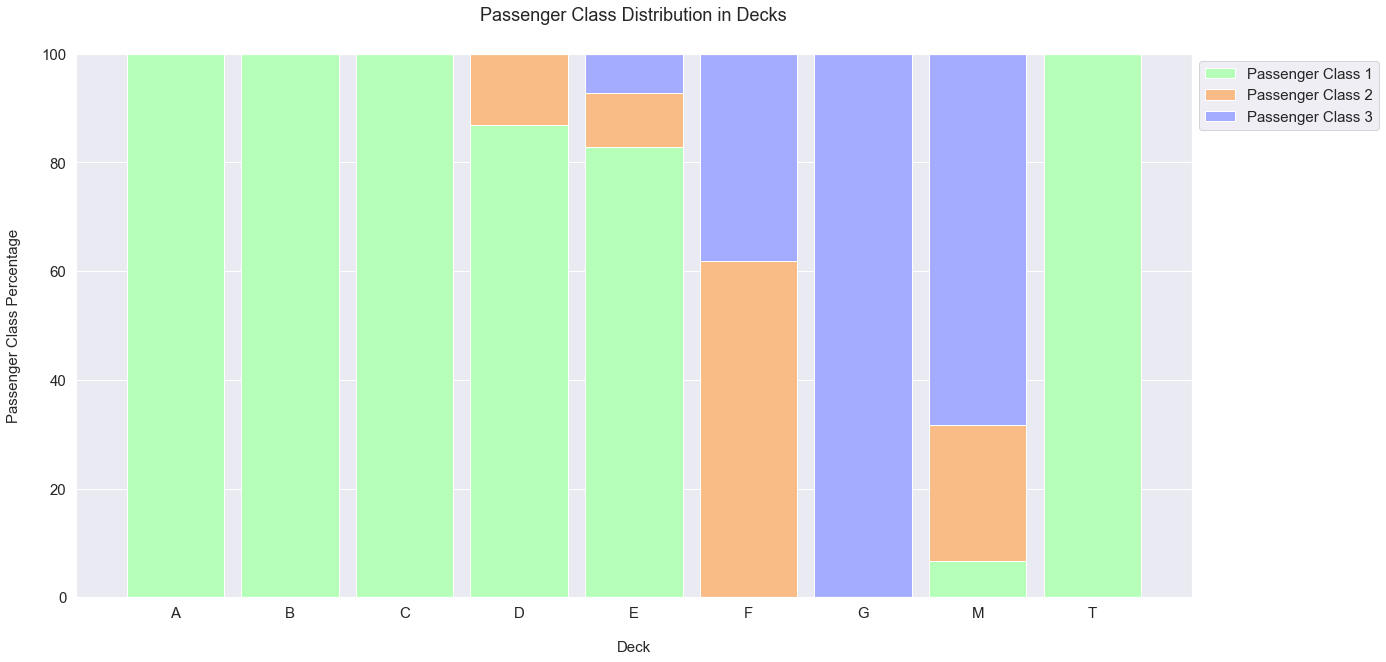

In [96]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xticks(bar_count, deck_names)
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

>>> * **100%** of **A**, **B** and **C** decks are 1st class passengers.
* Deck **D** has **87%** 1st class and **13%** 2nd class passengers.
* Deck **E** has **83%** 1st class, **10%** 2nd class and **7%** 3rd class passengers.
* Deck **F** has **62%** 2nd class and **38%** 3rd class passengers.
* **100%** of **G** deck are 3rd class passengers.
* There is one person on the boat deck in the **T** cabin and he is a 1st class passenger. **T** cabin passenger has the closest resemblance to **A** deck passengers, so he is grouped in **A** deck.
* Passengers labeled as **M** are the missing values in the `Cabin` feature. I don't think it is possible to find those passengers' real `Deck`. I decided to use **M** like a deck itself.

In [97]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

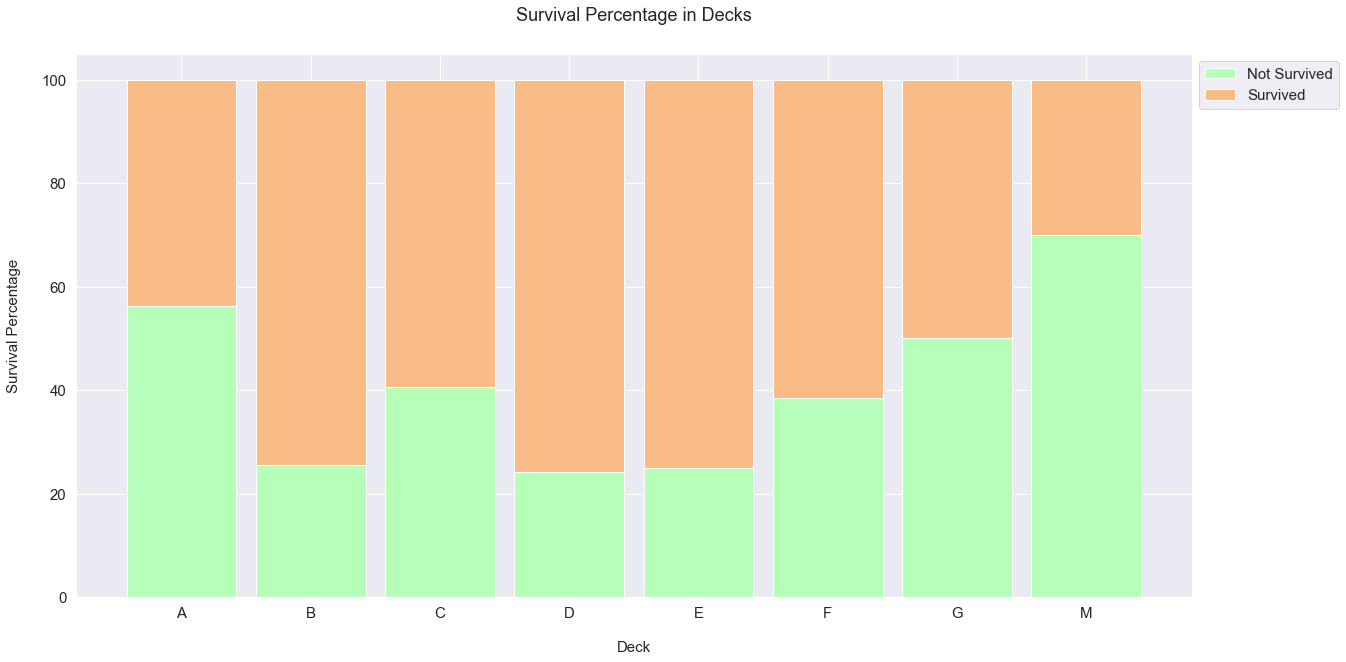

In [98]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")

    plt.xticks(bar_count, deck_names)
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

In [99]:
df_all.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Deck'],
      dtype='object')

In [100]:
df_all.dtypes

Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex             object
SibSp            int64
Survived       float64
Ticket          object
Deck            object
dtype: object

In [101]:
df_all.shape

(1309, 13)

In [102]:
df_all['Survived'].shape

(1309,)

>>> As I suspected, every deck has different survival rates and we can't discard this information. Deck **B**, **C**, **D** and **E** have the highest survival rates. Those decks are mostly occupied by 1st class passengers. **M** has the lowest survival rate which is mostly occupied by 2nd and 3rd class passengers. To conclude cabins used by 1st class passengers have higher survival rates than cabins used by 2nd and 3rd class passengers. In my opinion **M** (Missing `Cabin` values) has the lowest survival rate because they couldn't retrieve the cabin data of the victims. That's why I believe, labeling that group as **M** is a reasonable way to handle the missing data. It is a unique group with same characteristics. `Deck` feature has high-cardinality right now, so some of the values are grouped with each other depending on their resemblance.
* **A**, **B** and **C** decks are labeled as **ABC** because all of them have only 1st class passengers.
* **D** and **E** decks are labeled as **DE** because both of them have similar passenger class distribution and same survival rate.
* **F** and **G** decks are labeled as **FG** because of the former reason.
* **M** deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate.

In [105]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FGM')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FGM      26
Name: Deck, dtype: int64

In [106]:
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




>> ### **1.3. Survival Distribution**
* **38.38%** (342/891) of the training set is **Class 1**.
* **61.62%** (549/891) of the training set is **Class 0**.

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


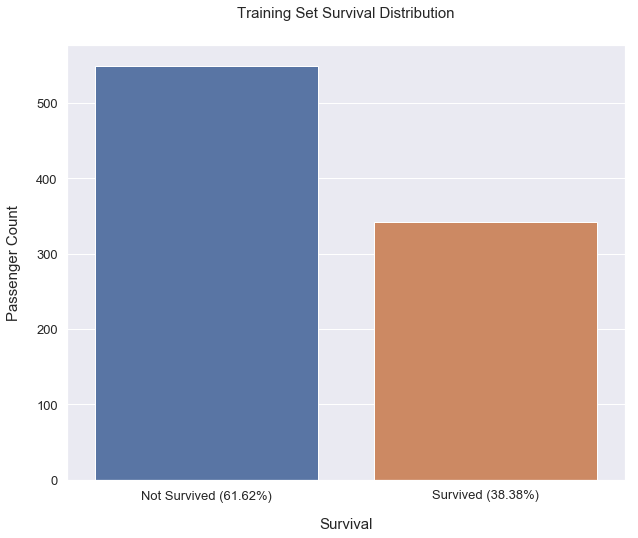

In [107]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

plt.figure(figsize=(10, 8))
sns.countplot(df_train['Survived'])

plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

>> ### **1.4. Correlations**
* Features are highly correlated with each other and dependent to each other.
* The highest correlation between features is **0.549500** in training set and **0.577147** in test set (between `Fare` and `Pclass`).
* The other features are also highly correlated. There are **9** correlations in training set and **6** correlations in test set that are higher than **0.1**.

In [108]:
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [109]:
# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

Feature 1 Feature 2  Correlation Coefficient
6     Pclass      Fare                 0.549500
8     Pclass       Age                 0.417667
10     SibSp     Parch                 0.414838
12  Survived    Pclass                 0.338481
14  Survived      Fare                 0.257307
16     SibSp       Age                 0.249747
18     Parch      Fare                 0.216225
20       Age     Parch                 0.176733
22     SibSp      Fare                 0.159651
24       Age      Fare                 0.124061

In [110]:
# Test set high correlations
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

Feature 1 Feature 2  Correlation Coefficient
6       Fare    Pclass                 0.577489
8        Age    Pclass                 0.526789
10       Age      Fare                 0.345347
12     SibSp     Parch                 0.306895
14      Fare     Parch                 0.230410
16     SibSp      Fare                 0.172032

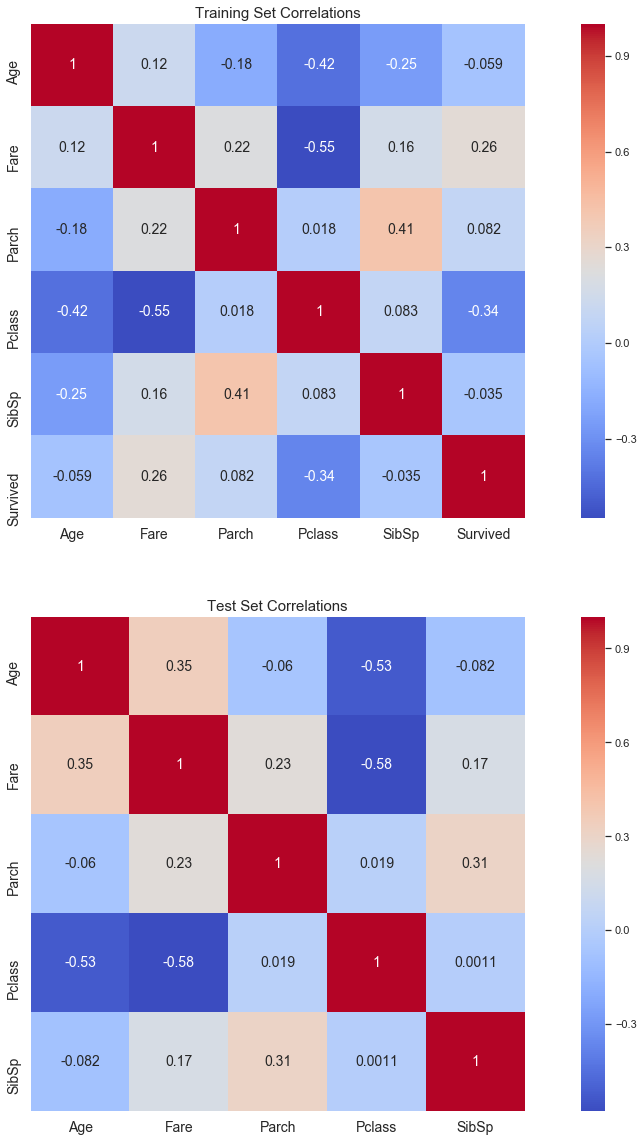

In [111]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

>> ### **1.5. Survival Distribution in Features**

>>> #### **1.5.1. Continuous Features**
* Both of the continuous features, `Age` and `Fare`, have good split points and spikes for a decision tree.
* Distribution of `Age` feature clearly shows that children younger than 15 has a higher survival rate than any of the other age groups.
* In the distribution of `Fare` feature, the survival rate is higher on distribution tails. The distribution also has positive skew because of the extreme outliers.
* One potential problem for both features is, the distribution of the spikes are bumpy in training set, but smooth in test set. The machine learning algorithm may not able to generalize to test set because of this reason.

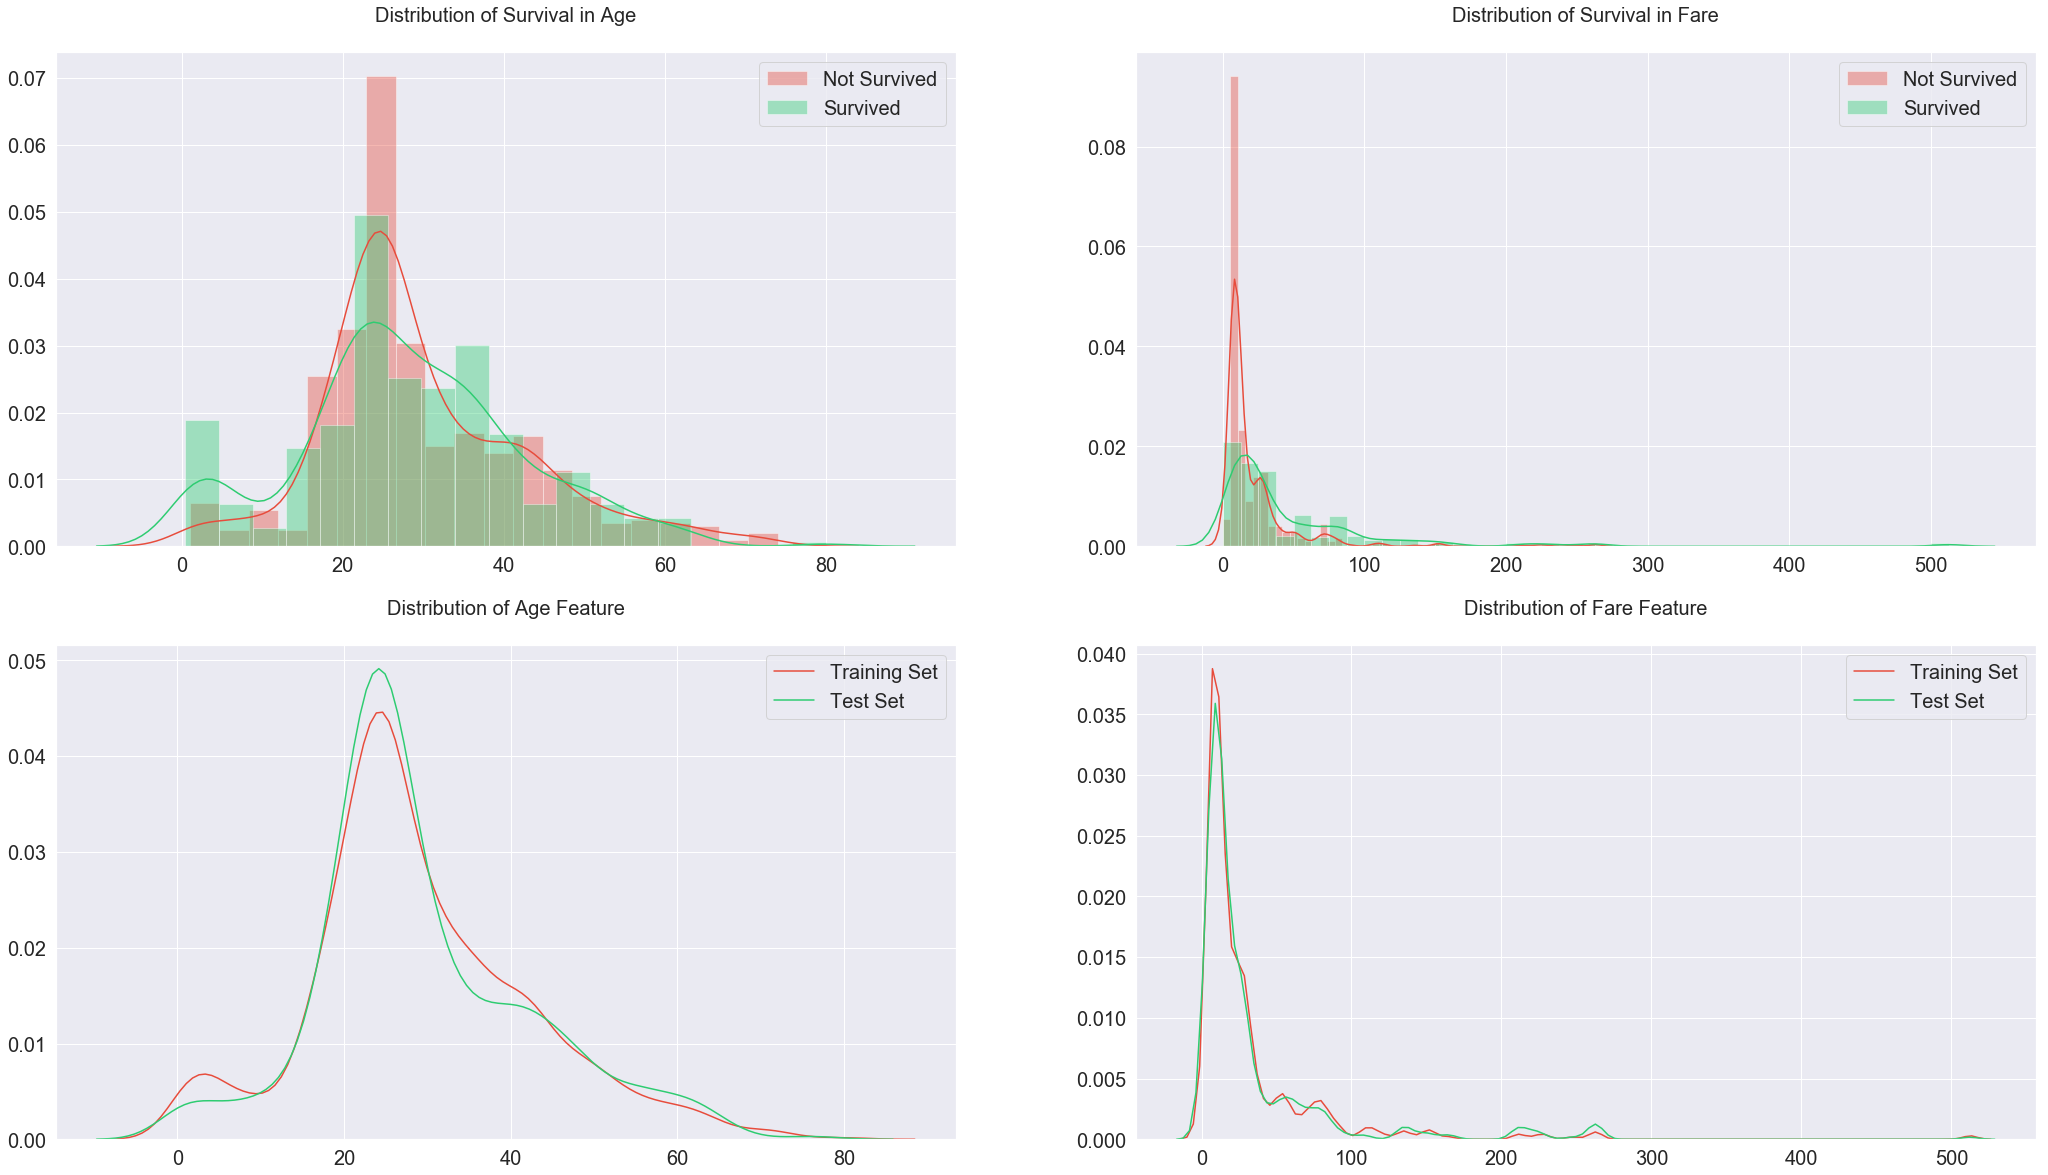

In [112]:
cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_xlabel('')
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)
    
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].set_xlabel('')
    
axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

>>> #### **1.5.2. Categorical Features**
* Every categorical feature has at least one class with high not-survived rate. Those classes will be very helpful to predict whether the passenger is a survivor or victim.
* Passengers boarded from **Southampton** has a lower survival rate unlike other ports.More than half of the passengers boarded from **Cherbourg** did survive.
* `Parch` and `SibSp` features show that passengers with one family member has a higher survival rate.
* Best categorical features are `Pclass` and `Sex` because they have the highest survived/not-survived ratio in a single class.

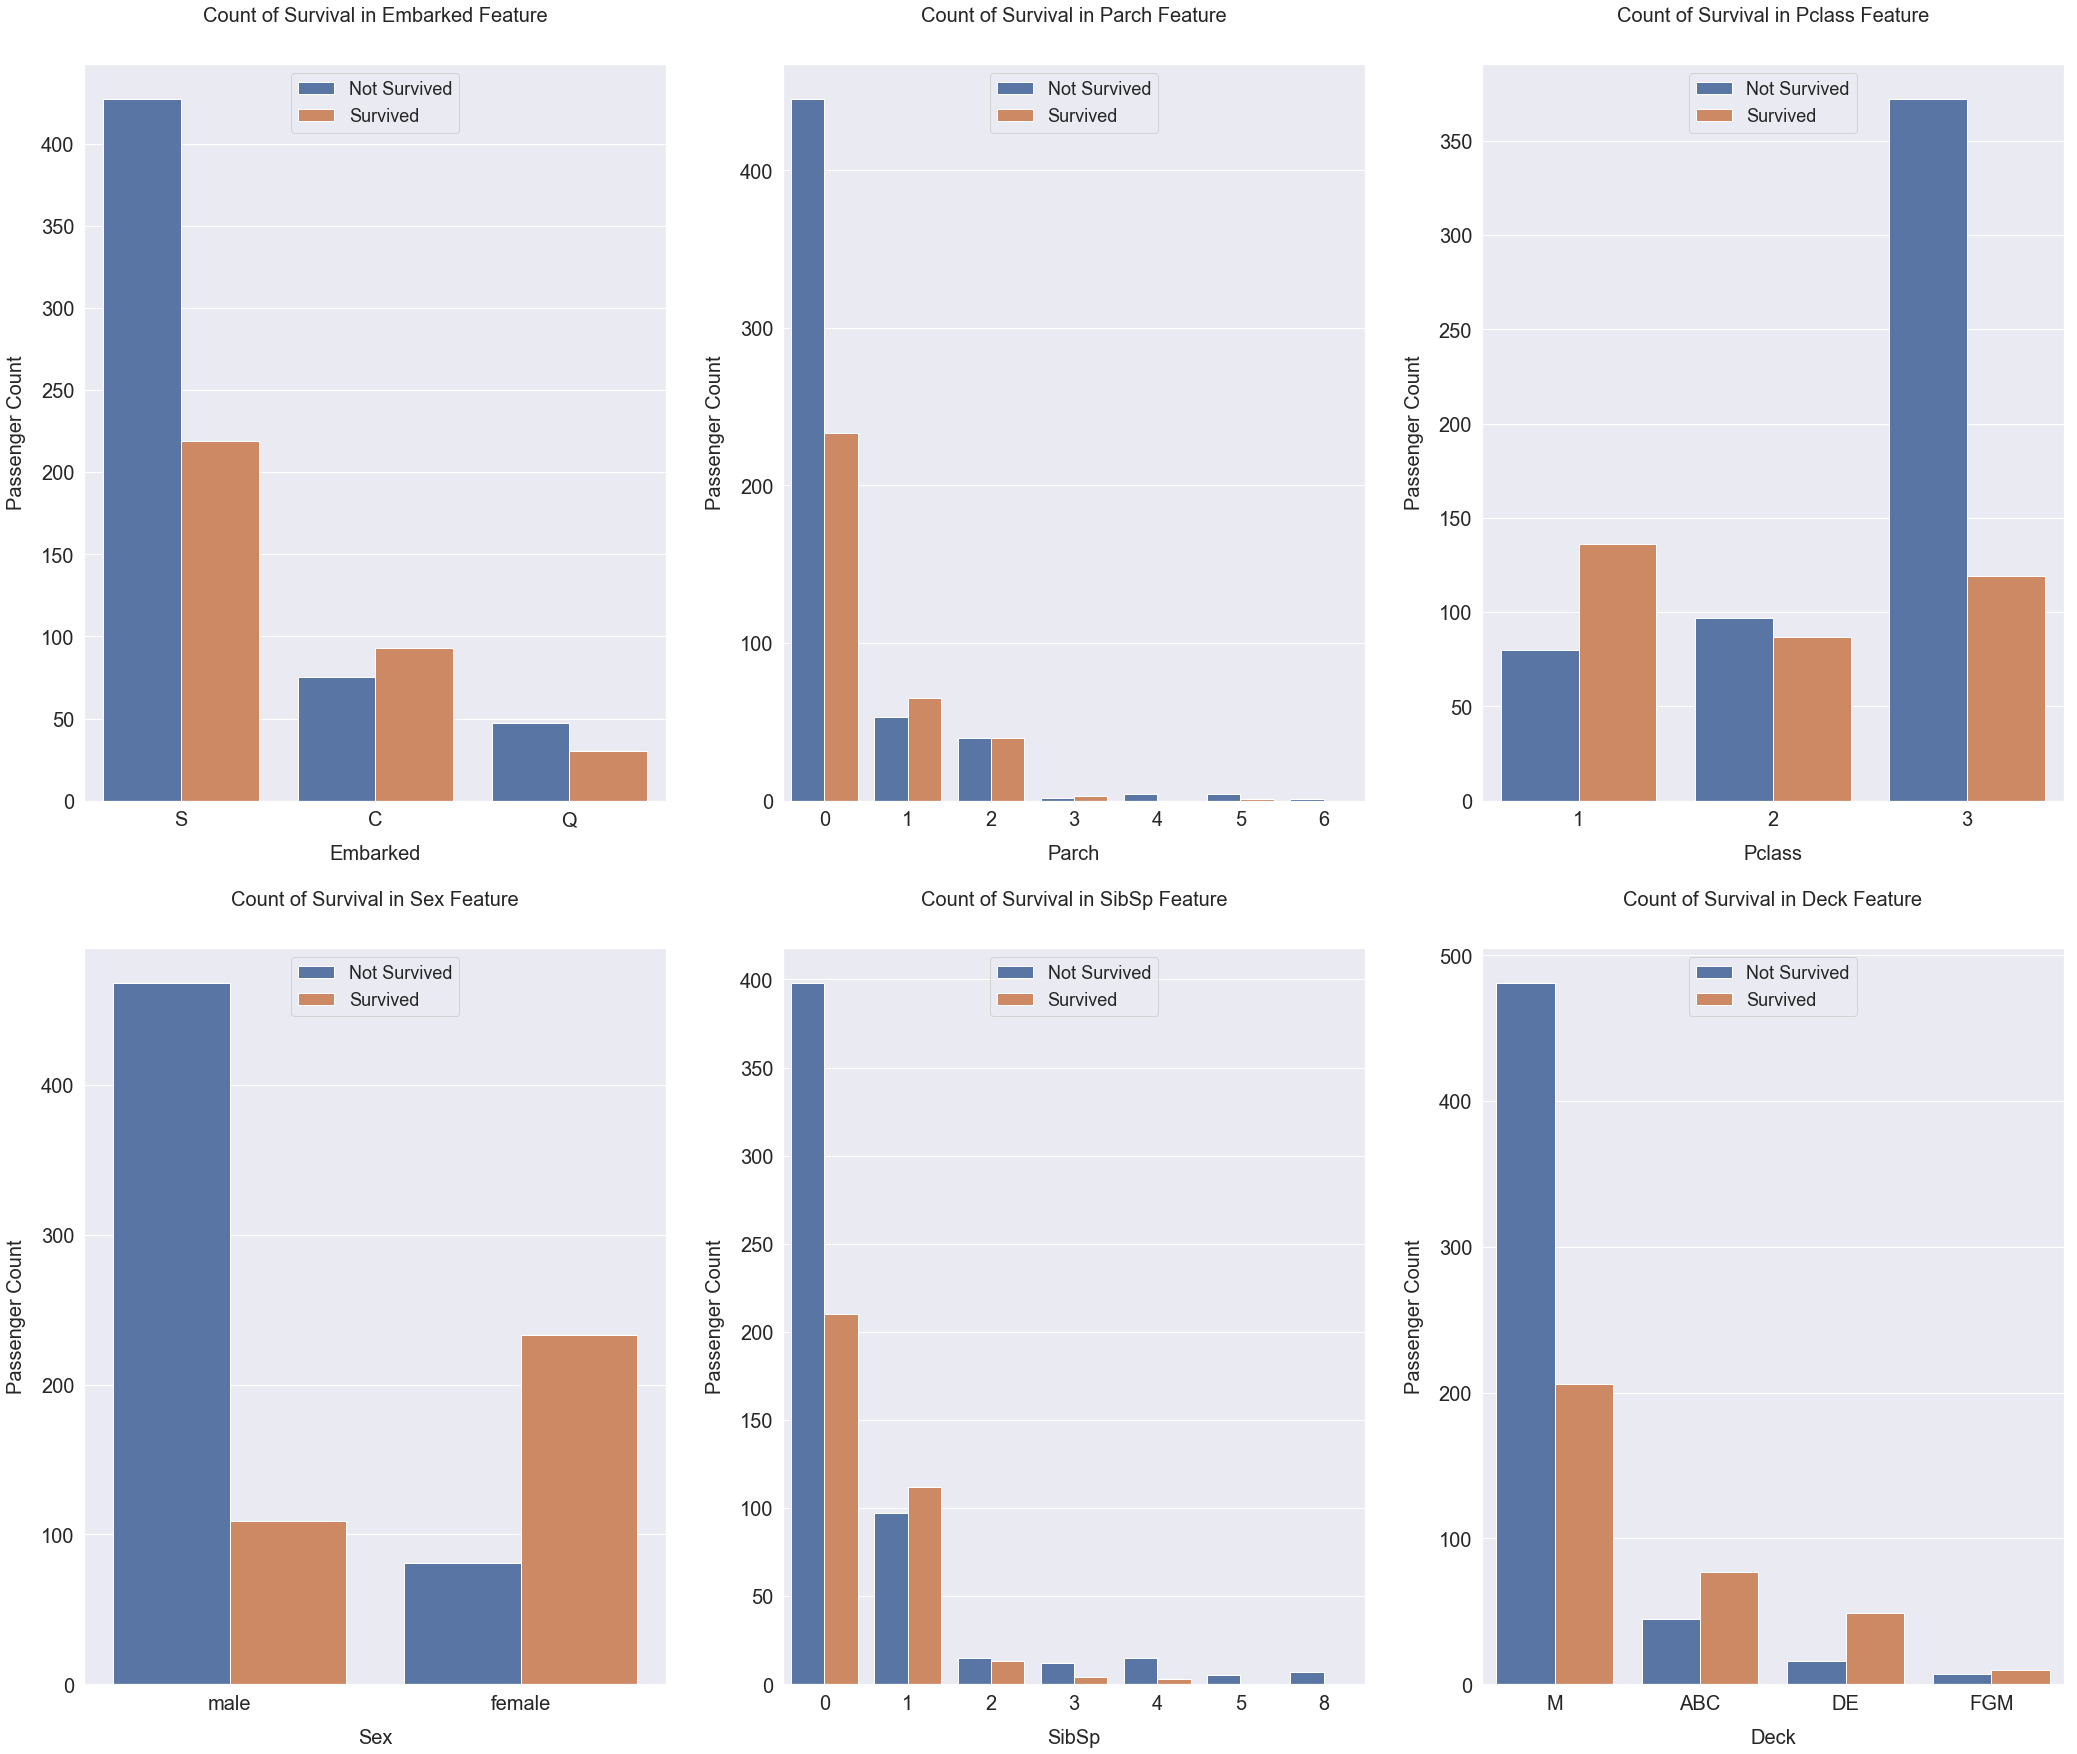

In [113]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):
    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)
    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

>>> #### **1.5.3. Ticket Frequency**
* There were too many `Ticket` values to analyze, so grouping them up by frequency makes things easier. **How is this feature different than family size (`Parch` and `SibSp`)?** Many passengers travelled along with a group. Those groups consist of friends, nannies, maids and etc. They werent counted as family, but they used the same ticket.
* According to the graph, groups with **2**,**3** and **4** members had a higher rate of survival.
* Passengers who travel alone has the lowest survival rate.
* After **4** group members, the survival rate decreases drastically.

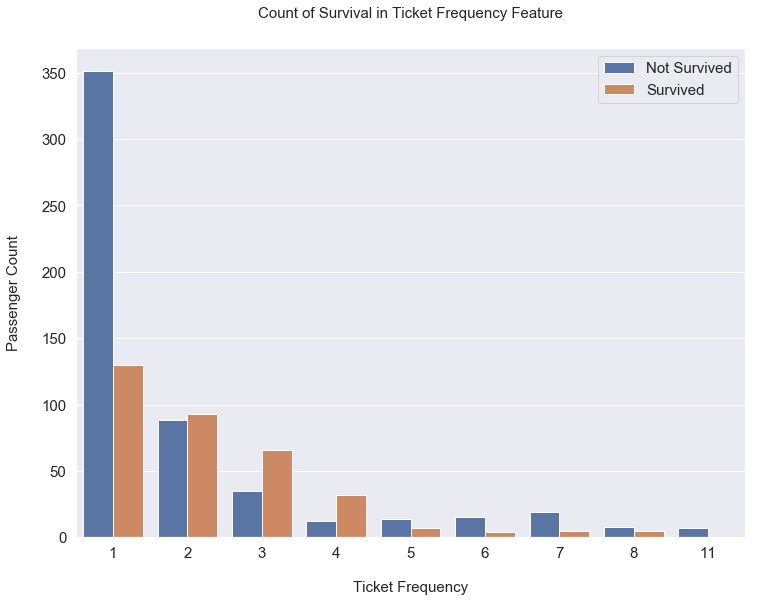

In [114]:
df_train['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count').values[:891]
df_test['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count').values[891:]

fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_train)

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

>> ### **1.6. Conclusion**
* Most of the features are correlated with each other. This relationship can be used to create new features with feature transformation and interaction. Target encoding could be very useful as well because of the high correlations with `Survived` feature.
* Split points and spikes are very visible in the continuous feature. They can be captured easily with a decision tree, but neural networks may not be able to spot them.
* Categorical features have very distinct classes with different survival rates. Some of those informations might also be combined to make new features.
* Created **2** new features (`Deck` and `Ticket_Frequency`) and dropped **1** feature (`Cabin`) at the Exploratory Data Analysis part.

In [115]:
df_all = concat_df(df_train, df_test)
df_all.head()

Age Deck Embarked     Fare  \
0  22.0    M        S   7.2500   
1  38.0  ABC        C  71.2833   
2  26.0    M        S   7.9250   
3  35.0  ABC        S  53.1000   
4  35.0    M        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

   Pclass     Sex  SibSp  Survived            Ticket  Ticket_Frequency  
0       3    male      1       0.0         A/5 21171                 1  
1       1  female      1       1.0          PC 17599                 2  
2       3  female      0       1.0  STON/O2. 3101282                 1  
3       1  female      1       1.0            113803                 2  
4       3    male      0       0.0            373450                 1

> ## **2. Feature Engineering**

>> ### **2.1. Binning the Continuous Features**

>>> #### **2.1.1. Fare**
* `Fare` feature is positively skewed and survival rate is extremely high on the right end.
* **13** quantile based bins are used for `Fare` feature. Even though it is too much, it provides decent amount of information gain.
* The groups in the left side of the graph has the lowest survival rate and the groups in the right side of the graph has the highest survival rate. This high survival rate was not visible in the distribution graph.
* There is also an unusual group **(15.742, 23.25]** with high survival rate that is captured in this process.

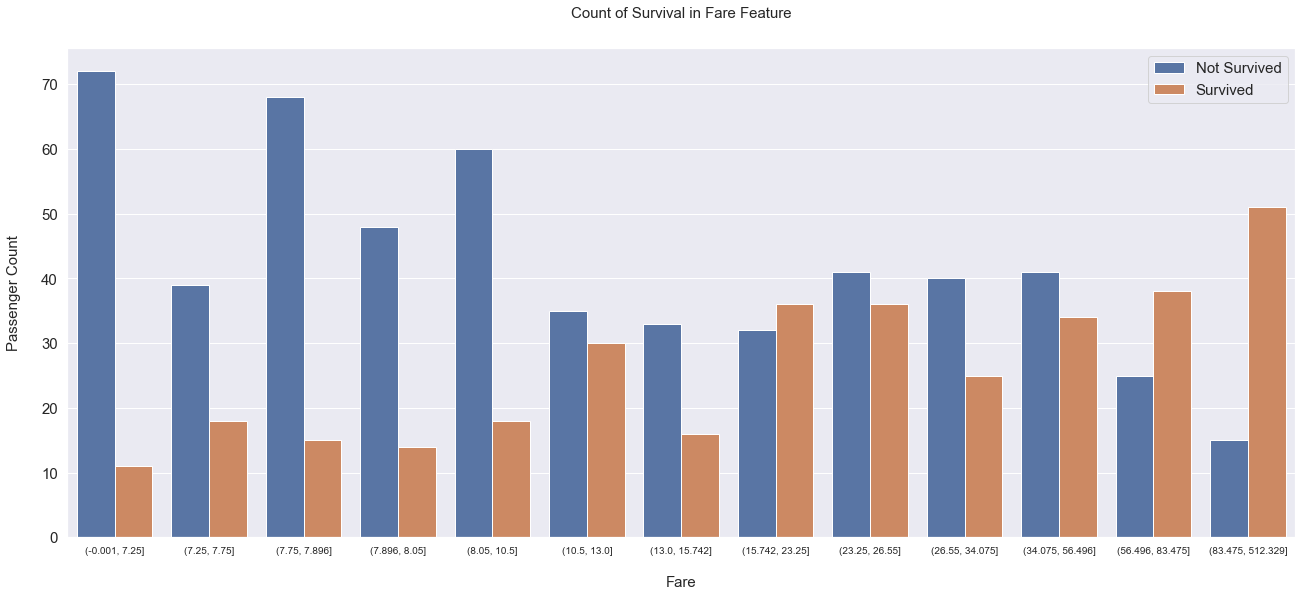

In [116]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)
plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

>>> #### **2.1.2. Age**
* `Age` feature has a normal distribution with some spikes and bumps.
* **10** quantile based bins are used for `Age` feature.
* The first bin has the highest survival rate and 4th bin has the lowest survival rate. Those were the spikes in the distribution.
* There is also an unusual group **(34.0, 40.0]** with high survival rate that is captured in this process.

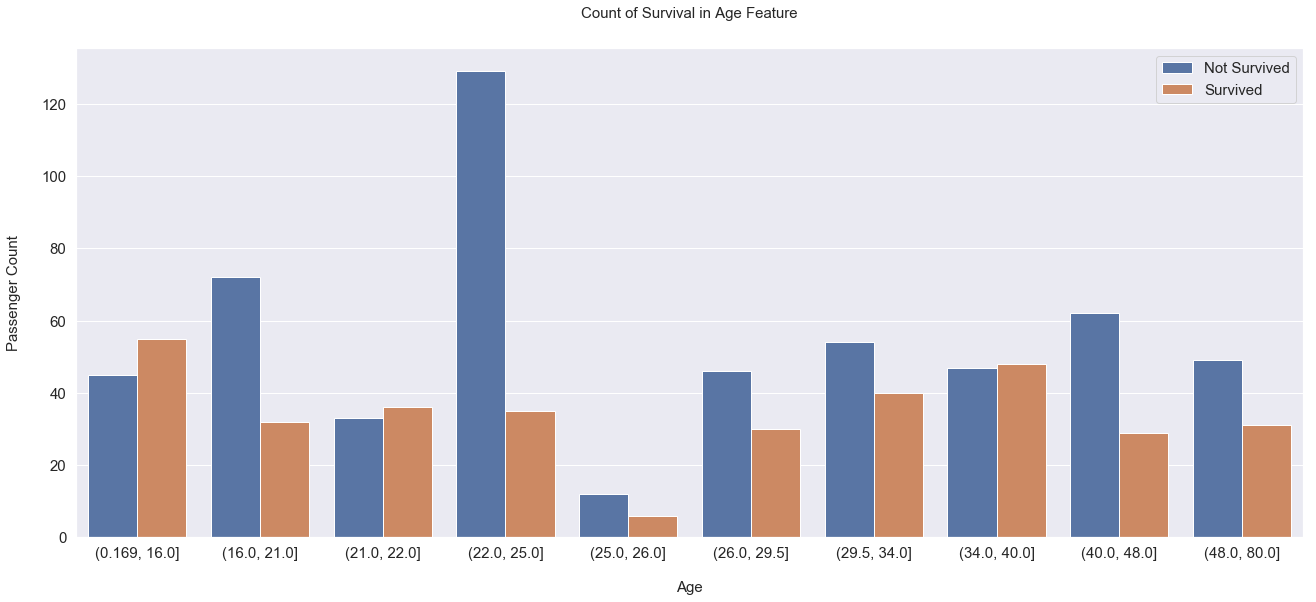

In [117]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.title('Count of Survival in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

>> ### **2.2. Family Size**
* `Family_Size` is created by adding `SibSp`, `Parch` and **1**. `SibSp` is the count of siblings and spouse, and `Parch` is the count of parents and children. Those columns are added to find the total size of families. Adding **1** at the end, is the passenger.
* Graphs have clearly shown that family size is a predictor of survival because different values have different survival rates.
* Family Size with **1** are labeled as **Alone**.
* Family Size with **2**, **3** and **4** are labeled as **Small**.
* Family Size with **5** and **6** are labeled as **Medium**.
* Family Size with **7**, **8** and **11** are labeled as **Large**.

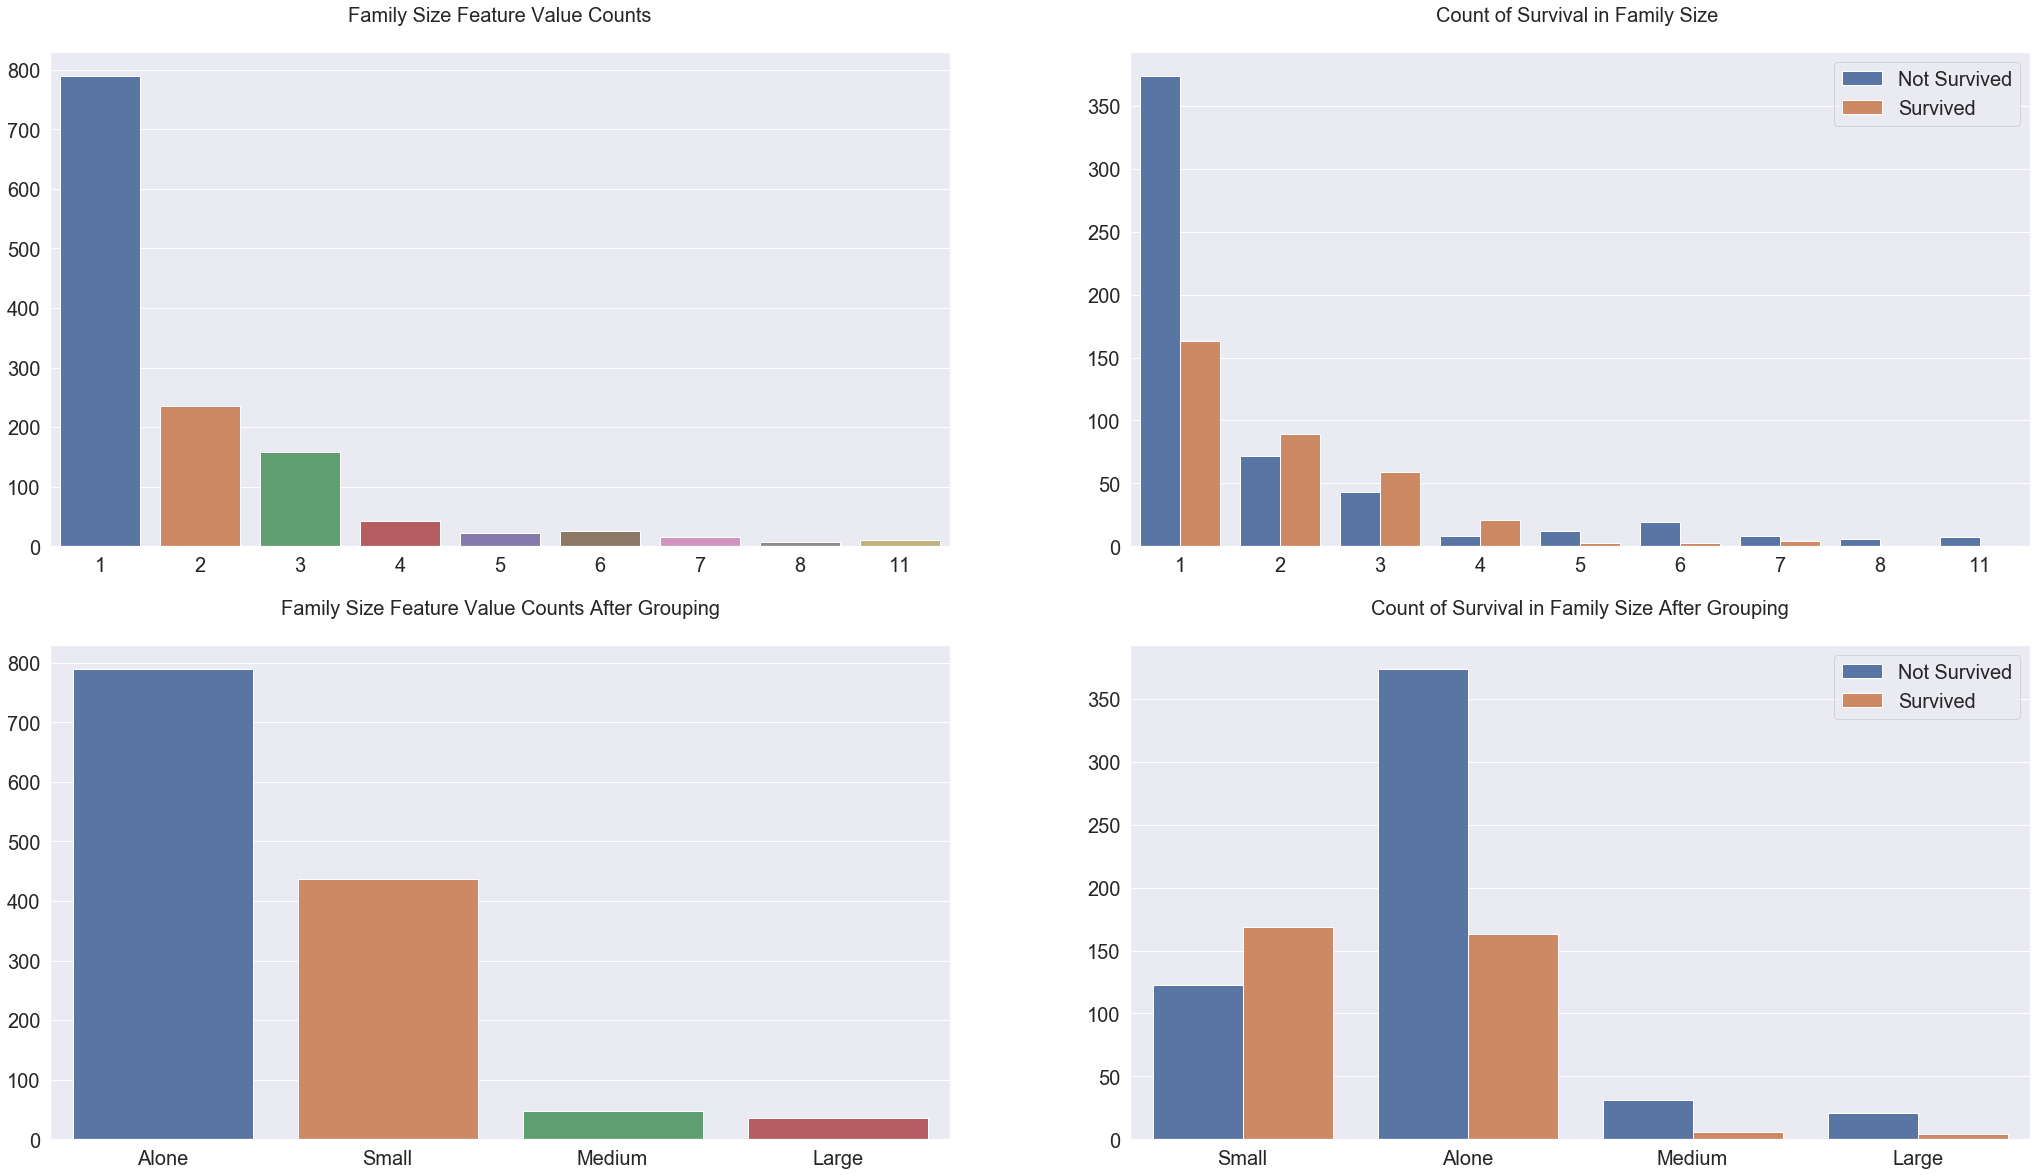

In [118]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])
axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Count of Survival in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])
axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Count of Survival in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

>> ### **2.3. Title & Is Married**
* `Title` is created by extracting the prefix before the `Name` column values.
* `Is_Married` is a binary feature based on the **Mrs** title. **Mrs** title has the highest survival rate among other female titles. This title needs to be a feature itself because other female titles are grouped with each other.
* According to the graph below, there are many titles which are occuring very few times. Some of those titles doesn't seem correct and they need to be replaced.
* **Miss**, **Mrs**, **Ms**, **Mlle**, **Lady**, **Mme**, **the Countess**, **Dona** titles are replaced with **Miss/Mrs/Ms** because all of them are actually females. Values like **Mlle**, **Mme** and **Dona** are actually the name of the passengers, but they are classified as titles because `Name` feature is split by comma.
* **Dr**, **Col**, **Major**, **Jonkheer**, **Capt**, **Sir**, **Don** and **Rev** titles are replaced with **Dr/Military/Noble/Clergy** because those passengers have similar characteristics.
* **Master** is a unique title. It is given to male passengers below age **26**. They have the highest survival rate among all male groups.

In [119]:
df_all['Name']

0                                 Braund, Mr. Owen Harris
1       Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                  Heikkinen, Miss. Laina
3            Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                                Allen, Mr. William Henry
5                                        Moran, Mr. James
6                                 McCarthy, Mr. Timothy J
7                          Palsson, Master. Gosta Leonard
8       Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                     Nasser, Mrs. Nicholas (Adele Achem)
10                        Sandstrom, Miss. Marguerite Rut
11                               Bonnell, Miss. Elizabeth
12                         Saundercock, Mr. William Henry
13                            Andersson, Mr. Anders Johan
14                   Vestrom, Miss. Hulda Amanda Adolfina
15                       Hewlett, Mrs. (Mary D Kingcome) 
16                                   Rice, Master. Eugene
17            

In [120]:
df_all['Name'].str.split(',', expand=True)[1].str.split('.',expand=True)[0].value_counts()

 Mr              757
 Miss            260
 Mrs             197
 Master           61
 Dr                8
 Rev               8
 Col               4
 Mlle              2
 Ms                2
 Major             2
 Dona              1
 the Countess      1
 Don               1
 Jonkheer          1
 Mme               1
 Sir               1
 Capt              1
 Lady              1
Name: 0, dtype: int64

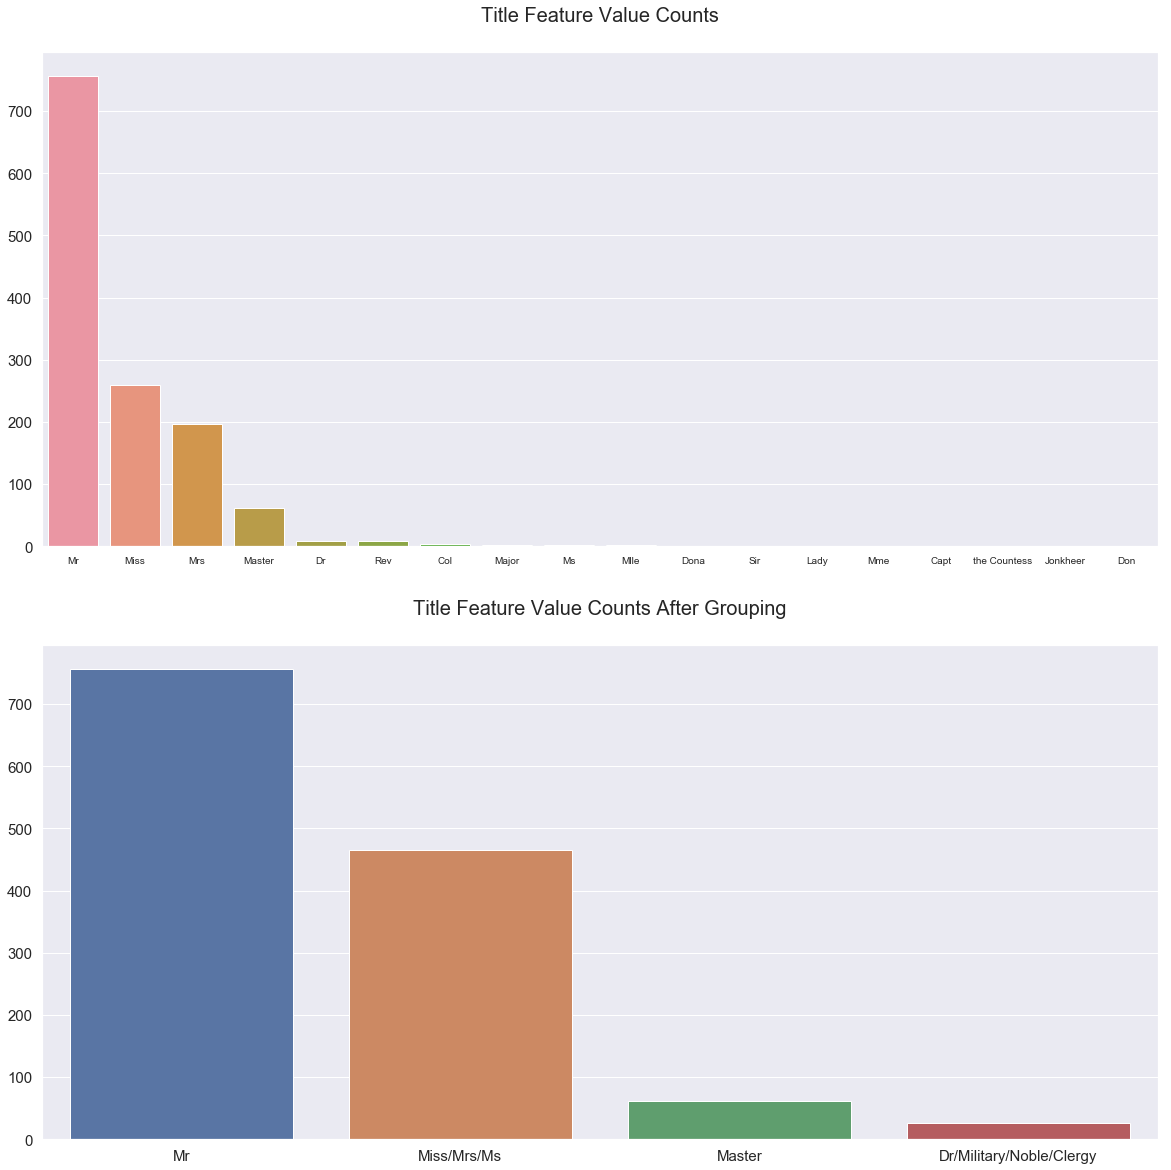

In [121]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])
axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

>> ### **2.4. Survival Rate**
* The first part of the feature, `Family_Survival_Rate`, is shared by [**@volhaleusha**](https://www.kaggle.com/volhaleusha) in this kernel [**Titanic: Tutorial, Encoding, Feature Eng, 81.8%**](https://www.kaggle.com/volhaleusha/titanic-tutorial-encoding-feature-eng-81-8), and it increases LB score significantly. However, it doesn't take passengers travelling with groups into consideration. Those groups doesn't necessarily have to be families. In order to overcome this problem, `Ticket_Survival_Rate` is also calculated and averaged with `Family_Survival_Rate`.
* `extract_surname` function is used to extract the surname of the passenger from the `Name` feature. `Family` feature is created with the extracted surname. This is necessary for grouping the passengers in the same family. 
* Family survival rate is calculated from the families in training set since there is no `Survived` feature in test set.
* A list of family names that are occuring in both training and test set, is created. The survival rate is calculated for families in that list and with more than 1 member, and stored in `Family_Survival_Rate` feature.
* An extra binary feature `Family_Survival_Rate_NA` is created for families that are unique to the test set. This feature is also necessary because there is no way to calculate those families' survival rate. This feature implies that family survival rate is not applicable to that passenger because there is no way to retrieve survival rate.
* `Ticket_Survival_Rate` and `Ticket_Survival_Rate_NA` features are also created the same method.
* `Ticket_Survival_Rate` and `Family_Survival_Rate` are averaged and become `Survival_Rate`, and `Ticket_Survival_Rate_NA` and `Family_Survival_Rate_NA` are averaged and become `Survival_Rate_NA`.

In [122]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

# Returning a list of families that are occuring in both training and test set
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
df_family_survival_rate = df_train.groupby('Family')['Survived', 'Family','Family_Size'].median()

family_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

In [123]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

In [124]:
# Returning a list of tickets that are occuring in both training and test set
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]
df_ticket_survival_rate = df_train.groupby('Ticket')['Survived', 'Ticket','Ticket_Frequency'].median()

ticket_rates = {}

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]
        
train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2
    

>> ### **2.5. Feature Transformation**

>>> #### **2.5.1. Label Encoding the Non-Numerical Features**
`Embarked`, `Sex`, `Deck` , `Title` and `Family_Size_Grouped` are object type, and `Age` and `Fare` features are category type. They are converted to numerical type with `LabelEncoder`. `LabelEncoder` basically labels the classes from **0** to **n**. This process is necessary for Machine Learning algorithms to learn from those features.

In [125]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

In [126]:
df_train['Age'].value_counts()

3    164
1    104
0    100
7     95
6     94
8     91
9     80
5     76
2     69
4     18
Name: Age, dtype: int64

>>> #### **2.5.2. One-Hot Encoding the Categorical Features**
The categorical features (`Pclass`, `Sex`, `Deck`, `Embarked`, `Title`) are converted to one-hot encoded features with `OneHotEncoder`. `Age` and `Fare` features are not converted because they are ordinal unlike the former ones.

In [127]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        print(n)
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

3
2
4
3
4
4
3
2
4
3
4
4


>> ### **2.6. Conclusion**
* `Age` and `Fare` features are binned. Binning helped dealing with outliers and it revealed some homogeneous groups in those features.
* `Family_Size` is created with the interaction between `Parch` and `SibSp` features.
* `Name` feature is very useful. First, `Title` and `Is_Married` features are created from the title prefix in the name values. Second, `Family_Survival_Rate` and `Family_Survival_Rate_NA`  features are created by target encoding the surname of the passengers.
* `Survival_Rate` feature is created by averaging the `Family_Survival_Rate` and `Ticket_Survival_Rate` features.
* Finally, the non-numeric type features are label encoded and categorical features are one-hot encoded.
* Created **5** new features (`Family_Size`, `Title`, `Is_Married`, `Survival_Rate` and `Survival_Rate_NA`) and dropped the useless features after encoding.

In [128]:
df_test.shape

(418, 44)

In [129]:
df_train.shape

(891, 44)

In [130]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

Age  Deck_1  Deck_2  Deck_3  Deck_4  Embarked_1  Embarked_2  Embarked_3  \
0    2     0.0     0.0     0.0     1.0         0.0         0.0         1.0   
1    7     1.0     0.0     0.0     0.0         1.0         0.0         0.0   
2    4     0.0     0.0     0.0     1.0         0.0         0.0         1.0   
3    7     1.0     0.0     0.0     0.0         0.0         0.0         1.0   
4    7     0.0     0.0     0.0     1.0         0.0         0.0         1.0   

   Family_Size_Grouped_1  Family_Size_Grouped_2   ...     Pclass_3  Sex_1  \
0                    0.0                    0.0   ...          1.0    0.0   
1                    0.0                    0.0   ...          0.0    1.0   
2                    1.0                    0.0   ...          1.0    1.0   
3                    0.0                    0.0   ...          0.0    1.0   
4                    1.0                    0.0   ...          1.0    0.0   

   Sex_2  Survival_Rate  Survival_Rate_NA  Ticket_Frequency  Title_1  Title_2  \
0    1.0       0.383838               0.0                 1      0.0      0.0   
1    0.0       1.000000               1.0                 2      0.0      0.0   
2    0.0       0.383838               0.0                 1      0.0      0.0   
3    0.0       0.383838               0.0                 2      0.0      0.0   
4    1.0       0.383838               0.0                 1      0.0      0.0   

   Title_3  Title_4  
0      0.0      1.0  
1      1.0      0.0  
2      1.0      0.0  
3      1.0      0.0  
4      0.0      1.0  

[5 rows x 26 columns]

> ## **3. Machine Learning**

In [131]:
X_train = df_train.drop(columns=drop_cols)
y_train = df_train['Survived']
X_test = df_test.drop(columns=drop_cols)
y_test =df_test['Survived']

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 26)
y_train shape: (891,)
X_test shape: (418, 26)


>> ### **3.1. Random Forest Classifier**

In [132]:
clf = RandomForestClassifier(criterion='gini', 
                            n_estimators=1100,
                            max_depth=5,
                            min_samples_split=4,
                            min_samples_leaf=5,
                            max_features='auto',
                            oob_score=True, 
                            random_state=SEED,
                            n_jobs=-1,
                            verbose=1) 

clf.fit(StandardScaler().fit_transform(X_train), y_train)
print('RandomForestClassifier oob score: {}'.format(clf.oob_score_))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    0.9s finished


RandomForestClassifier oob score: 0.8473625140291807


In [133]:
clf = RandomForestClassifier(oob_score=True) 

clf.fit(StandardScaler().fit_transform(X_train), y_train)
clf.predict(X_test)
print('RandomForestClassifier oob score: {}'.format(clf.oob_score_))

RandomForestClassifier oob score: 0.8125701459034792


In [134]:
from sklearn.model_selection import StratifiedKFold

X = X_train
y = y_train
skf = StratifiedKFold(n_splits=10, random_state=42)
skf.get_n_splits(X, y)

#print(skf) 
scores=[]

for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train)
    print(clf.score(X_test, y_test))
    scores.append(clf.score(X_test, y_test))

0.8444444444444444
0.8555555555555555
0.7528089887640449
0.8426966292134831
0.8651685393258427
0.8764044943820225
0.8426966292134831
0.7640449438202247
0.8876404494382022
0.8636363636363636


In [140]:
np.mean(scores)

0.8395097037793666

>> ### **3.2. Evaluation**

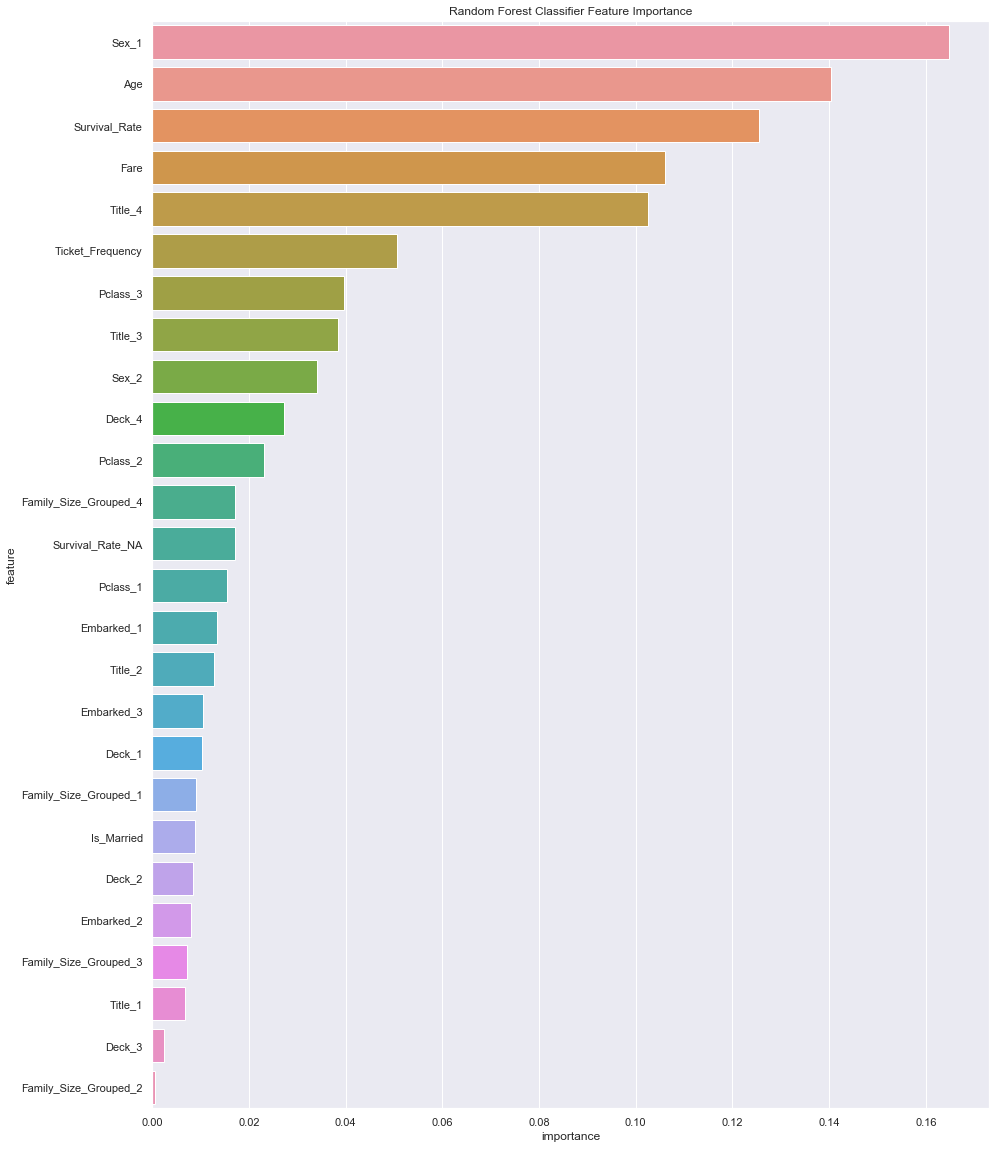

In [135]:
df_feature_importance = pd.DataFrame()
df_feature_importance['feature'] = X_train.columns
df_feature_importance['importance'] = clf.feature_importances_

plt.figure(figsize=(15, 20))
sns.barplot(x='importance', y='feature', data=df_feature_importance.sort_values(by='importance', ascending=False))
plt.title('Random Forest Classifier Feature Importance')
plt.show()

In [136]:
y_pred = clf.predict(StandardScaler().fit_transform(X_test)).astype(int)

#  Тест на новые характеристики

#### 1.  Есть ли прирост по точности от добавление новых сгенерированных характеристик:

In [142]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [143]:
train_df["Male"] = train_df.Sex.map({"male": 1, "female": 0}).astype(int)
test_df["Male"] = test_df.Sex.map({"male": 1, "female": 0}).astype(int)

train_df["FamilySize"] = train_df.SibSp + train_df.Parch + 1
test_df["FamilySize"] = test_df.SibSp + train_df.Parch + 1

train_df = train_df.drop(["PassengerId", "Ticket", "Cabin", "Name", "Sex", "SibSp", "Parch", "Embarked", "Fare"], axis=1)
test_df = test_df.drop(["Ticket", "Cabin", "Name", "Sex", "SibSp", "Parch", "Embarked", "Fare"], axis=1)

X = train_df.drop("Survived", axis=1).fillna(np.nan)
y = train_df.Survived
X_test = test_df.drop("PassengerId", axis=1).fillna(np.nan)


X.tail()

Pclass   Age  Male  FamilySize
886       2  27.0     1           1
887       1  19.0     0           1
888       3   NaN     0           4
889       1  26.0     1           1
890       3  32.0     1           1

In [144]:
combined = pd.concat([X, X_test])
imp = Imputer()
imp_df = pd.DataFrame(imp.fit_transform(combined))
imp_df.columns = combined.columns
imp_df.index = combined.index
combined["Age"] = imp_df["Age"]
print(combined.isnull().sum())

X = combined[:len(X)]
X_test = combined[len(X):]
X.tail()

Pclass        0
Age           0
Male          0
FamilySize    0
dtype: int64


Pclass        Age  Male  FamilySize
886       2  27.000000     1         1.0
887       1  19.000000     0         1.0
888       3  29.881138     0         4.0
889       1  26.000000     1         1.0
890       3  32.000000     1         1.0

In [151]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(oob_score=True) 
scores = cross_val_score(clf , X, y)
print(scores.mean())

0.8013468013468014


In [154]:
X = X_train
y = y_train
skf = StratifiedKFold(n_splits=10, random_state=42)
skf.get_n_splits(X, y)

scores=[]

for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train)
    print(clf.score(X_test, y_test))
    scores.append(clf.score(X_test, y_test))

0.8356164383561644
0.7534246575342466
0.7671232876712328
0.7671232876712328
0.9178082191780822
0.863013698630137
0.7916666666666666
0.8472222222222222
0.8732394366197183
0.8028169014084507


In [155]:
np.mean(scores)

0.8219054815958152

## Таким образом: с генерацией фичей мы получили 1% прирост точности по кросс валидации 10- фолдов.

#### 2. Есть ли прирост по точноти от добавления заполнения пропусков возраста:

In [157]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [158]:
train_df["Male"] = train_df.Sex.map({"male": 1, "female": 0}).astype(int) # альтернатива OneHotEncoding
test_df["Male"] = test_df.Sex.map({"male": 1, "female": 0}).astype(int)

train_df = train_df.drop(["PassengerId", "Ticket", "Cabin", "Name", "Sex", "SibSp", "Parch", "Embarked", "Fare", 'Age'], axis=1)
test_df = test_df.drop(["Ticket", "Cabin", "Name", "Sex", "SibSp", "Parch", "Embarked", "Fare",'Age'], axis=1)

X = train_df.drop("Survived", axis=1).fillna(np.nan)
y = train_df.Survived
X_test = test_df.drop("PassengerId", axis=1).fillna(np.nan)


X.tail()

Pclass  Male
886       2     1
887       1     0
888       3     0
889       1     1
890       3     1

In [159]:
X = X_train
y = y_train
skf = StratifiedKFold(n_splits=10, random_state=42)
skf.get_n_splits(X, y)

scores=[]

for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train)
    print(clf.score(X_test, y_test))
    scores.append(clf.score(X_test, y_test))

0.7910447761194029
0.7727272727272727
0.8
0.7846153846153846
0.8153846153846154
0.9538461538461539
0.8461538461538461
0.7692307692307693
0.8153846153846154
0.8153846153846154


In [160]:
np.mean(scores)

0.8163772048846676

Итого, заполнение пропусков и добавление количества членов семьи дает только 1% прироста по точности